In [2]:
from bs4 import BeautifulSoup as bs4
import requests
import pandas as pd
import time
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, MaxAbsScaler
from scipy.spatial.distance import cdist
import numpy as np
"""
pip install bs4
pip install requests
pip install pandas
pip install tslearn
pip install scipy
"""
# Cài đặt và import các thư viện cần thiết

'\npip install bs4\npip install requests\npip install pandas\npip install tslearn\npip install scipy\n'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
"""
pip install numpy
pip install matplotlib
"""
# Import các thư viện vẽ biểu đồ

'\npip install numpy\npip install matplotlib\n'

In [4]:
#stock_symbols = ['HPG','AAA','DRL','ACB','AAM', 'ABS', 'ACC','AAT']

# Chọn các stock symbol cần thu thập dữ liệu
stock_symbols = ["HPG", "ABC", "BBC", "AST", "AGR", "APH", "CLC", "CEE", "CAV", "BMI", 
                "ADG", "ADS", "ANV", "CTG", "CTF", "DAH", "DCM", "DGW", "DAG", "DPM", 
                "DPR", "BCG", "BHN", "BIC", "BMC", "BTT", "BVH", "VCB", "VHM", "BID", 
                "VNM", "GAS", "NVL", "MBB", "SAB", "FPT", "VRE", "VPB", "PLX", "VJC", 
                "TPB", "STB", "HNG", "PDR", "SHB", "DIG", "HDB", "VND", "HVN", "DGC", 
                "SHP", "MSB", "HAG", "KBC", "VCI", "VCG", "LPB", "PNJ", "HSG", "BAB"]

In [14]:
# Hàm crawl dữ liệu các giá đóng cửa theo mã stock symbols
# Tham số đầu vào là list các stock symbols
# Đầu ra nhận được là list các data frame, mỗi data frame là dữ liệu giá đóng cửa mỗi ngày tương ứng với mỗi mã stock

def crawl(stock_symbols):
    #Tạo biến lưu dữ liệu list các data frame
    df_list = []
    
    # Duyệt qua các mã stock trong list
    for stock_symbol in stock_symbols:
        print('Getting data of:', stock_symbol+'...')
        
        n_page = 1 # Param truyền vào url để duyệt qua các page trên web
        date_list = [] # List lưu dữ liệu ngày
        close_price_list = [] # List lưu dữ liệu giá đóng cửa 
        
        # Vòng lặp duyệt qua các page trên web để crawl dữ liệu
        while (True):
            stop_crawl = False # Biến báo hiệu dừng crawl nếu stop_crawl True
            
            # Thực hiện request đến url trang web 
            agent = agent = {"User-Agent":"Mozilla/5.0"}
            url = ('https://cophieu68.vn/historyprice.php?currentPage={}&id={}').format(n_page, stock_symbol)
            page = requests.get(url,headers=agent,verify=False)
            soup = bs4(page.content, 'html.parser')
            
            # Truy vấn đến cấu trúc HTML để lấy dữ liệu
            table = soup.find('table',class_='stock')
            tr_list = table.find_all('tr')
            
            if (len(tr_list) < 2):
                stop_crawl = True
                
            for tr in tr_list[1:]:
                td_list = tr.find_all('td')
                if len(td_list) > 5:
                    if '2021' not in td_list[1].text:
                        stop_crawl = True
                        break
                        
                    date_list.append(td_list[1].text)
                    close_price_list.append(float(td_list[5].text.replace('\n','')))

            # Điều kiện dừng crawl dữ liệu khi dữ liệu cần crawl không thuộc năm 2021 và khi page không có dữ liệu        
            if stop_crawl == True:
                break
            n_page = n_page + 1
        
        # Sắp xếp dữ liệu từ ngày đầu năm đến thời điểm hiện tại
        date_list.reverse()
        close_price_list.reverse()
        
        # Khởi tạo data frame để lưu dữ liệu
        data = {'Date':date_list,'Close price':close_price_list}
        df = pd.DataFrame(data = data)
        df_list.append(df)
    print("Done!")
    print("Number of symbols: ", len(stock_symbols))
    print("Number of symbols data: ", len(df_list))
    return df_list

In [15]:
df_list = crawl(stock_symbols)

Getting data of: HPG...
Getting data of: ABC...
Getting data of: BBC...
Getting data of: AST...
Getting data of: AGR...
Getting data of: APH...
Getting data of: CLC...
Getting data of: CEE...
Getting data of: CAV...
Getting data of: BMI...
Getting data of: ADG...
Getting data of: ADS...
Getting data of: ANV...
Getting data of: CTG...
Getting data of: CTF...
Getting data of: DAH...
Getting data of: DCM...
Getting data of: DGW...
Getting data of: DAG...
Getting data of: DPM...
Getting data of: DPR...
Getting data of: BCG...
Getting data of: BHN...
Getting data of: BIC...
Getting data of: BMC...
Getting data of: BTT...
Getting data of: BVH...
Getting data of: VCB...
Getting data of: VHM...
Getting data of: BID...
Getting data of: VNM...
Getting data of: GAS...
Getting data of: NVL...
Getting data of: MBB...
Getting data of: SAB...
Getting data of: FPT...
Getting data of: VRE...
Getting data of: VPB...
Getting data of: PLX...
Getting data of: VJC...
Getting data of: TPB...
Getting data of:

In [16]:
# Hàm dùng để export dữ liệu đã crawl theo cách 1
# Dữ liệu giá đóng cửa của mỗi mã sẽ được lưu trong thư mục dataset
# Dữ liệu giá của mỗi mã stock có thông tin ngày sẽ được lưu theo từng file với tên file là tên mã stock 
# Ví dụ: HPG.csv

def export_csv_files(df_list, stock_symbols):
    ds_dir = './dataset'
    if not os.path.exists(ds_dir):
        os.mkdir(ds_dir)

    print(f"Exporting dataset to %d csv files..." %(len(df_list)))
    for i in range(len(df_list)):
        file_name = stock_symbols[i] + ".csv"
        
        full_path = os.path.join(ds_dir, file_name)  
        df_list[i].to_csv(full_path)
    print("Done!")

In [17]:
# Hàm dùng để export dữ liệu đã crawl theo cách 2
# Tất cả dữ liệu giá sẽ được lưu trong 1 file csv duy nhất với mỗi dòng là dữ liệu giá của mỗi mã stock
# Các cột gồm tên mã stock và các cột giá trị của giá đóng cửa mỗi ngày

def export_csv_file(df_list, stock_symbols):
    rows_data = []
    print("Exporting dataset to csv file...")
    for i in range(len(df_list)):
        rows_data.append(df_list[i]["Close price"].to_numpy())
    df = pd.DataFrame(rows_data)
    df.insert(0, "Symbol", stock_symbols, False)
    df.to_csv("dataset.csv", header=False, index=False)
    print("Done!")

In [19]:
# Chọn 1 trong 2 cách để export dữ liệu
# Export dữ liệu theo cách 1
export_csv_files(df_list, stock_symbols)

Exporting dataset to 60 csv files...
Done!


In [18]:
# Export dữ liệu theo cách 2
export_csv_file(df_list, stock_symbols)

Exporting dataset to csv file...
Done!


In [20]:
# Hàm đọc dữ liệu từ các file khi dữ liệu crawl được export theo cách 1
# Đầu ra sẽ là list các data frame và list tên các mã stock

def read_csv_files():
    directory = os.getcwd().replace("\\","/") + "/dataset"
    df_list = []
    filename_list = []
    print("Loading data...")
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            df_list.append(pd.read_csv(directory + "/" +filename))
            filename_list.append(filename.replace(".csv",""))
    
    print("Done!")
    return df_list, filename_list

In [5]:
# Hàm đọc dữ liệu từ file dataset khi dữ liệu crawl được export theo cách 2
# Đầu ra là data frame chứa thông tin tổng hợp các giá đóng cửa theo mã stock

def read_csv_file():
    print("Loading data...")
    df = pd.read_csv("dataset.csv",header=None)
    print("Done!")
    return df

In [21]:
# Chọn 1 trong 2 cách để đọc file.

# Cách 1
df_list, stock_symbols = read_csv_files()

Loading data...
Done!


In [6]:
# Cách 2
df = read_csv_file()
df = df[df.columns[1:]] # Xử lý loại bỏ cột chứa tên mã stock để lấy dữ liệu phục vụ việc training.

Loading data...
Done!


In [27]:
# Hàm xử lý chỉ lấy dữ liệu giá và bỏ thông tin ngày khi dữ liệu được load theo cách 1
# Nếu dữ liệu được load theo cách 2 có thể bỏ qua hàm này
def load_series_list(df_list):
    series_list = []
    for df in df_list:
        series = df["Close price"].values.reshape(-1,1)
#         print(len(series))
        series_list.append(series)
    return series_list

In [ ]:
# series_list = load_series_list(df_list)
# series_list = np.array(series_list)
# series_list.shape

In [ ]:
# series_list = []
# for df in df_list:
#     series = df["Close price"]
#     series_list.append(series)
# print(series_list)

In [7]:
# Hàm kiểm tra số lượng data ở mỗi series
# Nếu các series có độ dài không bằng nhau hàm sẽ in ra các độ dài khác nhau và thông tin mã stock có độ dài ít hơn.
# Nếu các series có độ dài bằng nhau thì hàm sẽ in ra 1 giá trị duy nhất là độ dài chung của các series

def check_lengths(series_list):
    series_lengths = {len(series) for series in series_list}
    print("series_lengths:", series_lengths)
    max_len = max(series_lengths)

    for i in range(len(series_list)):
        if len(series_list[i]) < max_len:
            print(i,stock_symbols[i], len(series_list[i]))

In [8]:
check_lengths(np.array(df))
# check_lengths(series_list)

series_lengths: {244}


In [9]:
# Normalize data với TimeSeriesScalerMeanVariance

X_train = TimeSeriesScalerMeanVariance().fit_transform(df)
print(X_train.shape)
print(X_train.max())
print(X_train.min())

(60, 244, 1)
6.0821776488838
-4.121509689608899


In [10]:
# X_train = TimeSeriesScalerMeanVariance().fit_transform(series_list)
# print(X_train.shape)
# print(X_train.max())
# print(X_train.min())

In [11]:
# Hàm vẽ biểu đồ so sánh data trước và sau khi normalize của 5 series đầu tiên

def draw_compare_graph(origin_X, scaled_X):
    for i in range(5):
        print("Range of original series: " ,(origin_X[i].min(),origin_X[i].max()))
        print("Range of scaled series: ", (scaled_X[i].min(),scaled_X[i].max()))
        plt.figure()
        fig, axs = plt.subplots(1,2,figsize=(10,5))
        fig.suptitle('Series '+ str(i+1))
        axs[0].plot(origin_X[i])
        axs[1].plot(scaled_X[i])
        axs[0].set_title("Original Series")
        axs[1].set_title("Scaled Series")
#         plt.plot(origin_X[i])
#         plt.plot(scaled_X[i])
        plt.show()


Range of original series:  (27.57, 58.0)
Range of scaled series:  (-2.0922739181781025, 1.5180237514630177)


<Figure size 432x288 with 0 Axes>

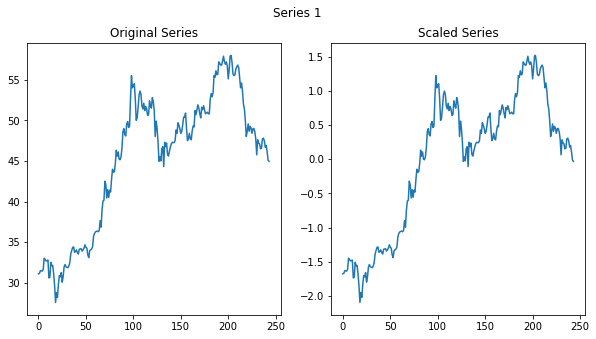

Range of original series:  (10.8, 19.5)
Range of scaled series:  (-1.8283547856531301, 2.428315031175631)


<Figure size 432x288 with 0 Axes>

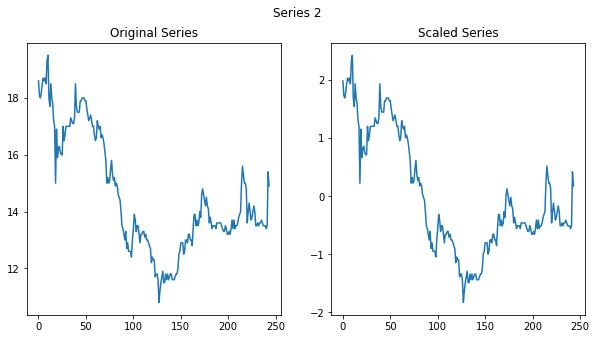

Range of original series:  (55.25, 84.0)
Range of scaled series:  (-2.2861773161395615, 6.0821776488838)


<Figure size 432x288 with 0 Axes>

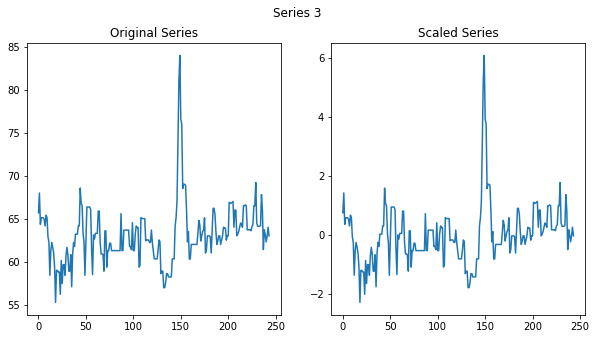

Range of original series:  (46.0, 65.6)
Range of scaled series:  (-1.7570972736540587, 2.2581655328841523)


<Figure size 432x288 with 0 Axes>

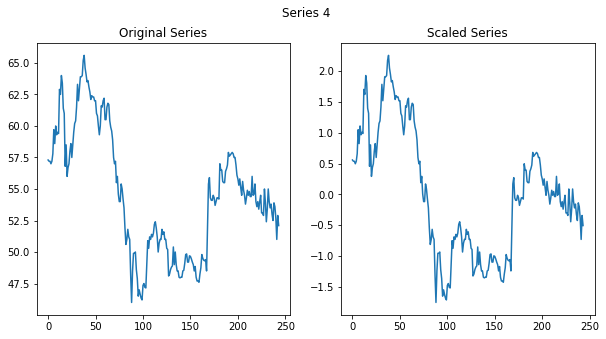

Range of original series:  (8.88, 27.7)
Range of scaled series:  (-1.403367111148291, 2.893856288663563)


<Figure size 432x288 with 0 Axes>

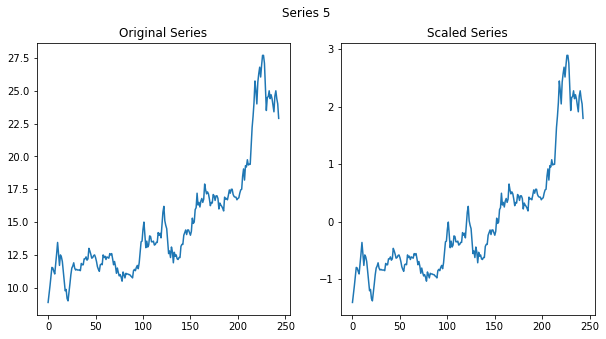

In [12]:
draw_compare_graph(df.to_numpy(), X_train)

In [33]:
# Hàm training 3 biến thể models k-means với các k khác nhau để tìm ra k tốt nhất
# Đầu ra là số K đã train và các chỉ số độ đo: 
#Inertias, Distortions, Calinski Harabasz Scores, Silhouette Scores, Davies_Bouldin Scores 

def get_models_metrics(X_train):
    start_time = time.time()
    seed = 12

    inertias = {"euclid": [], "dba": [], "sdtw": []}
    distortions = {"euclid": [], "dba": [], "sdtw": []}
    ch_scores = {"euclid":[],"dba":[], "sdtw":[]}
    db_scores = {"euclid":[], "dba":[], "sdtw":[]}
    s_scores = {"euclid": [], "dba": [], "sdtw": []}

    nsamples, nx, ny = X_train.shape

    K = range(2,16)
    for k in K:
        print("Training with k =", k,"...")
        print("Euclidean k-means...")
        km = TimeSeriesKMeans(n_clusters=k, verbose=False, random_state=seed)
        km.fit(X_train)

        # DBA-k-means
        print("DBA k-means...")
        dba_km = TimeSeriesKMeans(n_clusters=k,
                                  n_init=2,
                                  metric="dtw",
                                  verbose=False,
                                  max_iter_barycenter=10,
                                  random_state=seed)
        dba_km.fit(X_train)

        # Soft-DTW-k-means
        print("Soft-DTW k-means...")
        sdtw_km = TimeSeriesKMeans(n_clusters=k,
                                   metric="softdtw",
                                   metric_params={"gamma": .01},
                                   verbose=False,
                                   random_state=seed)

        sdtw_km.fit(X_train)

        inertias["euclid"].append(km.inertia_)
        inertias["dba"].append(dba_km.inertia_)
        inertias["sdtw"].append(sdtw_km.inertia_)

        ch_scores["euclid"].append(calinski_harabasz_score(X_train.reshape((nsamples,nx*ny)), km.labels_))
        ch_scores["dba"].append(calinski_harabasz_score(X_train.reshape((nsamples,nx*ny)), dba_km.labels_))
        ch_scores["sdtw"].append(calinski_harabasz_score(X_train.reshape((nsamples,nx*ny)), sdtw_km.labels_))

        s_scores["euclid"].append(silhouette_score(X_train.reshape((nsamples,nx*ny)), km.labels_))
        s_scores["dba"].append(silhouette_score(X_train.reshape((nsamples,nx*ny)), dba_km.labels_))
        s_scores["sdtw"].append(silhouette_score(X_train.reshape((nsamples,nx*ny)), sdtw_km.labels_))

        db_scores["euclid"].append(davies_bouldin_score(X_train.reshape((nsamples,nx*ny)), km.labels_))
        db_scores["dba"].append(davies_bouldin_score(X_train.reshape((nsamples,nx*ny)), dba_km.labels_))
        db_scores["sdtw"].append(davies_bouldin_score(X_train.reshape((nsamples,nx*ny)), sdtw_km.labels_))

        km_cc = km.cluster_centers_.shape
        dba_cc = dba_km.cluster_centers_.shape
        sdtw_cc = sdtw_km.cluster_centers_.shape

        km_cluster_centers = km.cluster_centers_.reshape(km_cc[0], km_cc[1]*km_cc[2])
        dba_cluster_centers = dba_km.cluster_centers_.reshape(dba_cc[0], dba_cc[1]*dba_cc[2])
        sdtw_cluster_centers = sdtw_km.cluster_centers_.reshape(sdtw_cc[0], sdtw_cc[1]*sdtw_cc[2])

        distortions["euclid"].append(sum(np.min(cdist(X_train.reshape((nsamples,nx*ny)), km_cluster_centers,'euclidean'), axis=1)) / X_train.shape[0])
        distortions["dba"].append(sum(np.min(cdist(X_train.reshape((nsamples,nx*ny)), dba_cluster_centers,'euclidean'), axis=1)) / X_train.shape[0])
        distortions["sdtw"].append(sum(np.min(cdist(X_train.reshape((nsamples,nx*ny)), sdtw_cluster_centers,'euclidean'), axis=1)) / X_train.shape[0])

    end_time = time.time()
    print("Done!")
    print(end_time - start_time)
    return K, inertias, distortions, ch_scores, s_scores, db_scores

In [34]:
K, inertias, distortions, ch_scores, s_scores, db_scores = get_models_metrics(X_train)

Training with k = 2 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 3 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 4 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 5 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 6 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 7 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 8 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 9 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 10 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 11 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 12 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 13 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 14 ...
Euclidean k

In [36]:
print(inertias)
print(distortions)
print(ch_scores)
print(s_scores)
print(db_scores)

{'euclid': [112.38526098045165, 89.72264499197432, 73.868642925417, 68.76975885447567, 60.23530338256412, 57.132914213159786, 57.348086180326376, 52.4821359139908, 47.618286188409954, 44.777216221311384, 42.300607051303345, 40.03442681015205, 37.66895876405478, 35.274911812491304], 'dba': [23.34911497667609, 18.25640747628066, 15.70313780394176, 13.871291479681059, 11.61253813137071, 11.407383250594853, 10.188921385099027, 9.326452134923784, 8.708650401512482, 8.118830741760219, 7.609639835584687, 7.119917225202857, 6.804204222930782, 6.406534963992842], 'sdtw': [843.0449211520562, 517.3607206993169, 371.51051836749826, 309.4347991115373, 195.47094292461645, 163.87978936182645, 148.3095178710009, 131.56056886827045, 120.46918415200687, 100.30182513700846, 86.37736959532624, 58.69864155170708, 57.111856467792286, 43.95953127759665]}
{'euclid': [10.036402627405373, 8.704649449035763, 7.99920003318059, 7.7840603727373745, 7.236883231732772, 7.091543984846538, 7.019677768998935, 6.76791507

In [43]:
# Hàm vẽ biểu đồ đánh giá mô hình phân cụm 
# Phương pháp đánh giá phụ thuộc vào loại độ đo
# Đầu vào là K, các giá trị của độ đo, Tên biểu đồ, Tiêu đề của cột y

def draw_evaluate_graph(K, y_val,title,y_label):
    plt.figure(figsize=(16,8))
    plt.plot(K, y_val, 'bx-')
    plt.xlabel('k')
    plt.ylabel(y_label)
    plt.xticks(K)
    plt.title(title)
    plt.show()

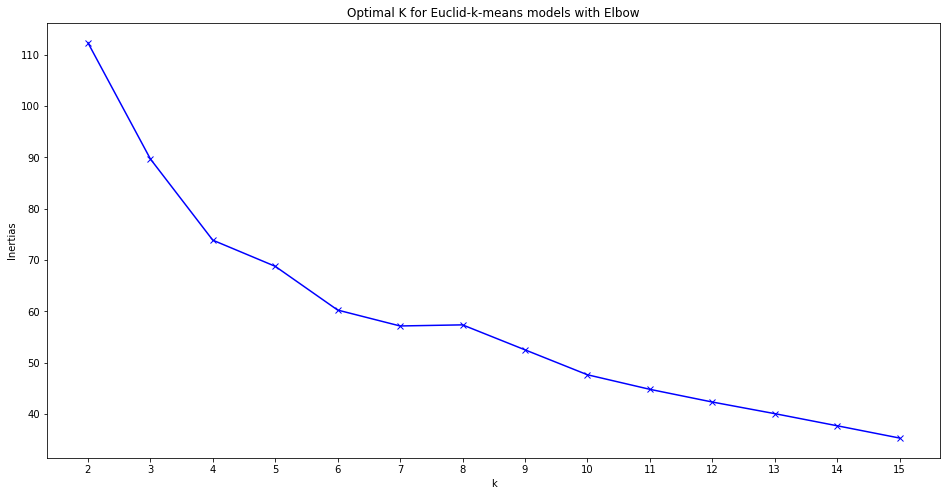

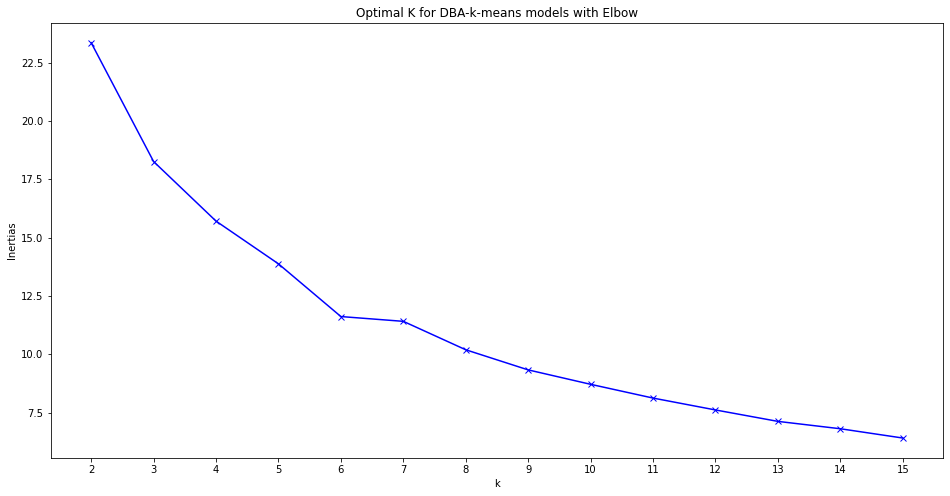

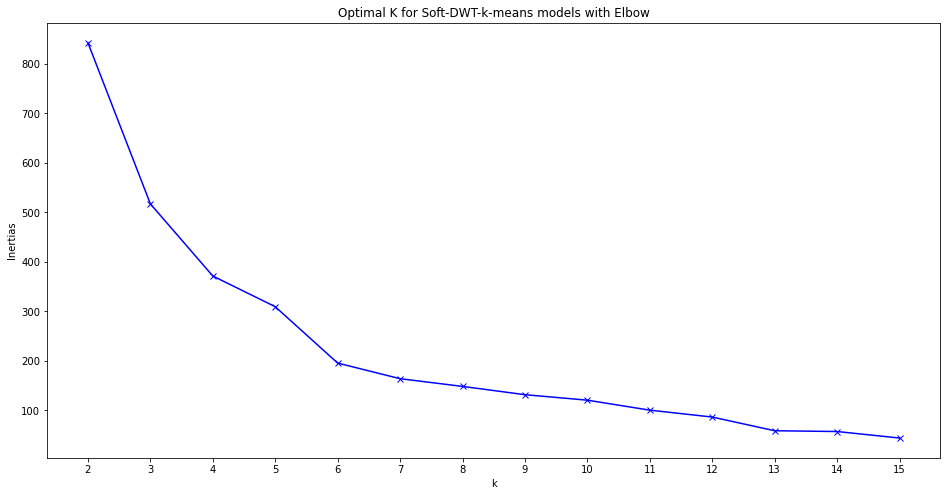

In [44]:
# Vẽ biểu đồ Elbow của 3 biến thể models với Inertias

draw_evaluate_graph(K, inertias["euclid"], "Optimal K for Euclid-k-means models with Elbow", "Inertias")
draw_evaluate_graph(K, inertias["dba"], "Optimal K for DBA-k-means models with Elbow", "Inertias")
draw_evaluate_graph(K, inertias["sdtw"], "Optimal K for Soft-DWT-k-means models with Elbow", "Inertias")

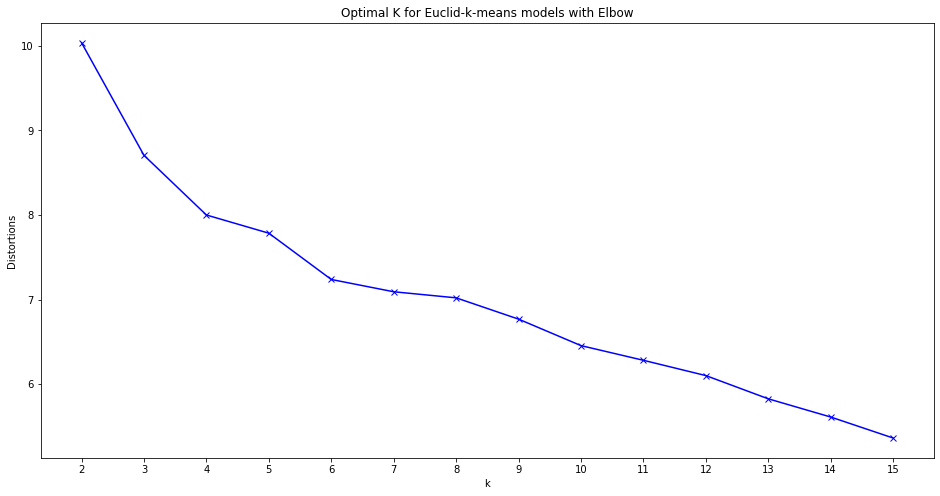

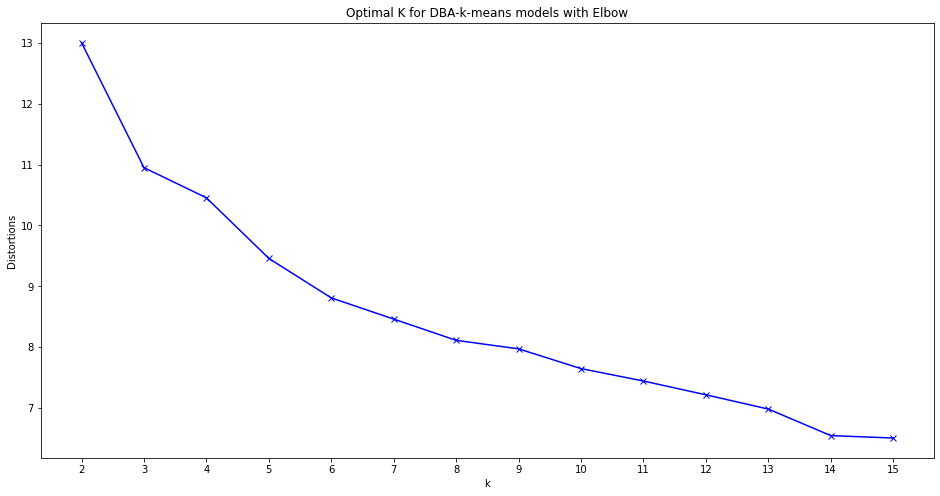

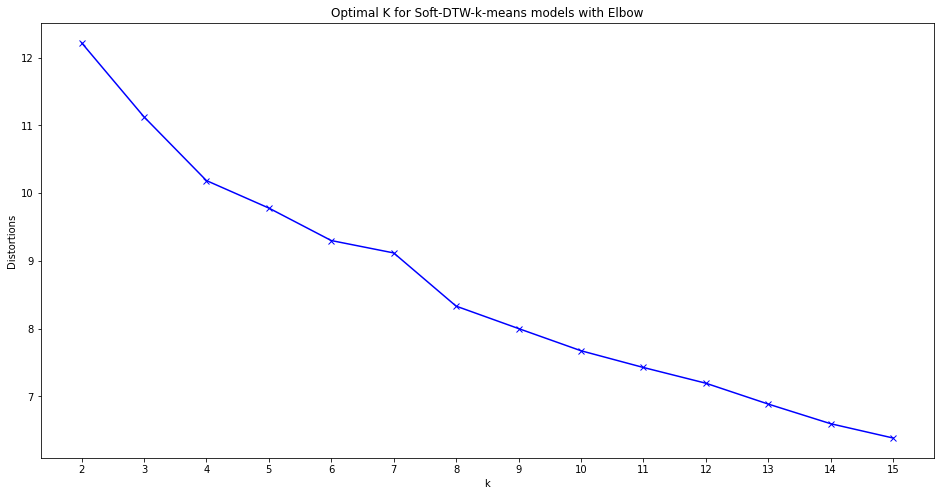

In [39]:
draw_evaluate_graph(K, distortions["euclid"], "Optimal K for Euclid-k-means models with Elbow", "Distortions")
draw_evaluate_graph(K, distortions["dba"], "Optimal K for DBA-k-means models with Elbow", "Distortions")
draw_evaluate_graph(K, distortions["sdtw"], "Optimal K for Soft-DTW-k-means models with Elbow", "Distortions")

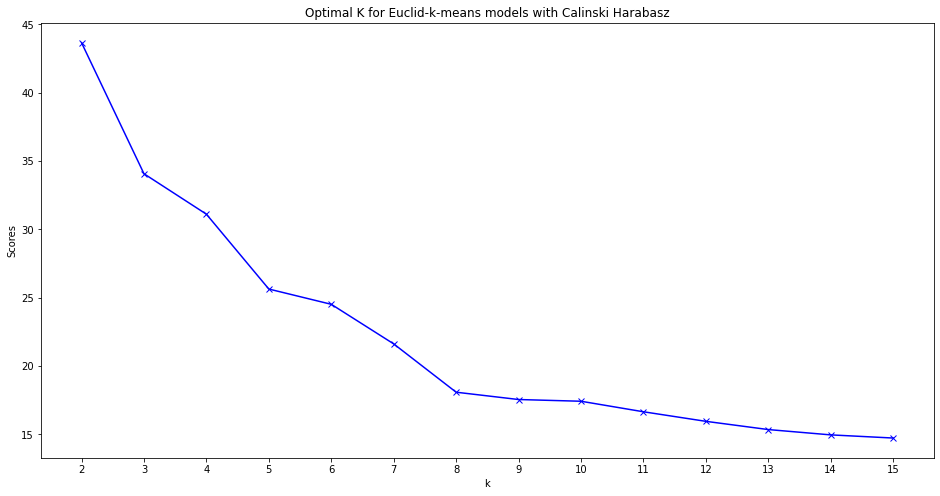

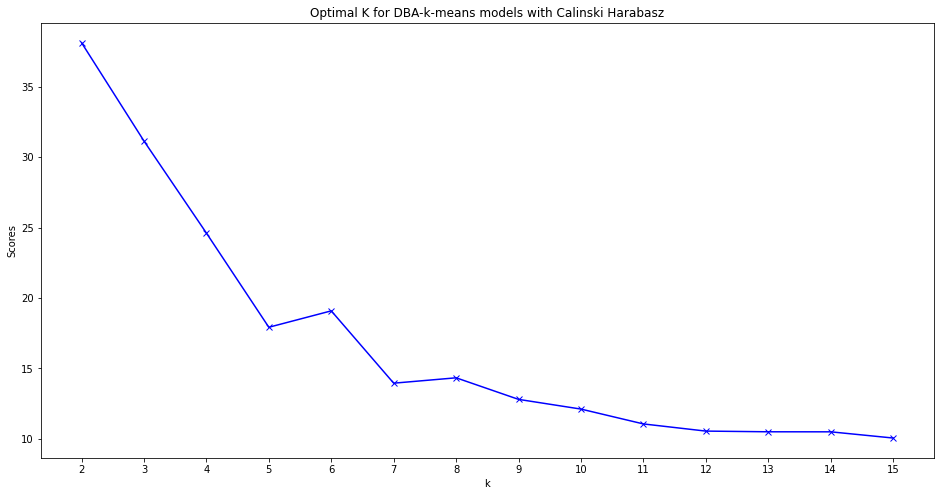

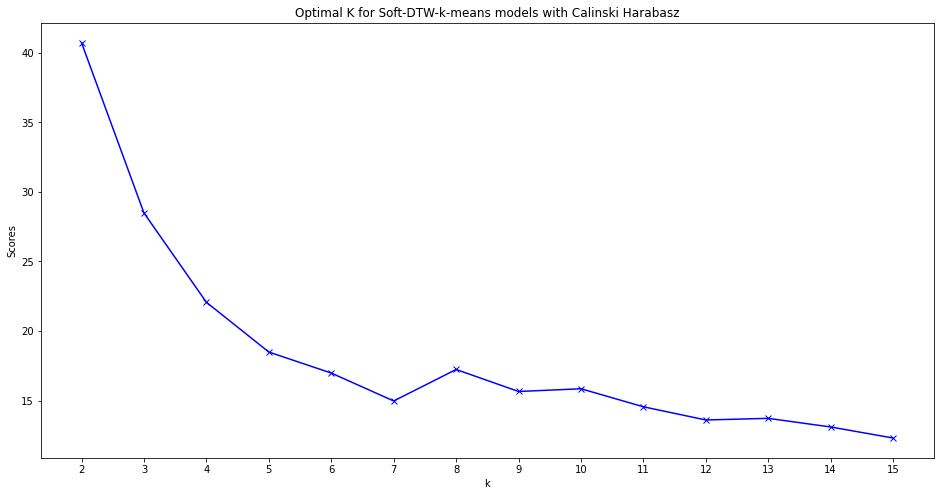

In [40]:
draw_evaluate_graph(K, ch_scores["euclid"],"Optimal K for Euclid-k-means models with Calinski Harabasz", "Scores")
draw_evaluate_graph(K, ch_scores["dba"],"Optimal K for DBA-k-means models with Calinski Harabasz", "Scores")
draw_evaluate_graph(K, ch_scores["sdtw"],"Optimal K for Soft-DTW-k-means models with Calinski Harabasz", "Scores")

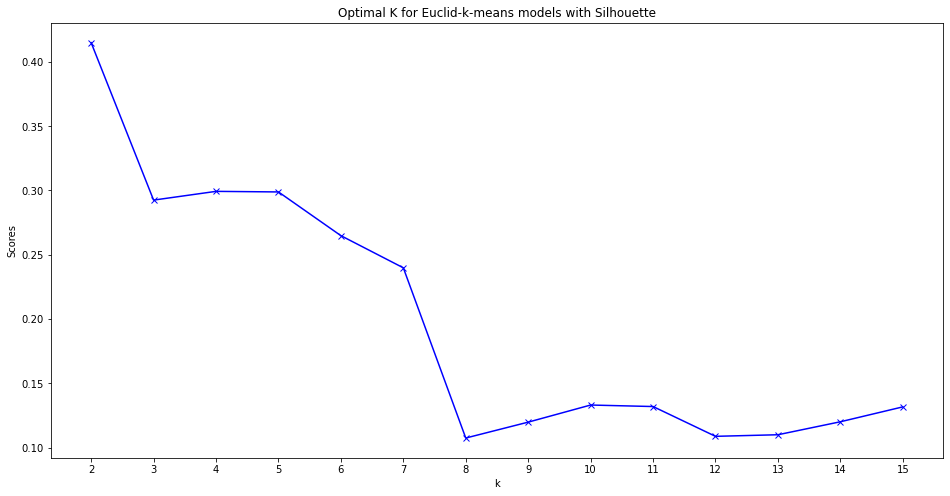

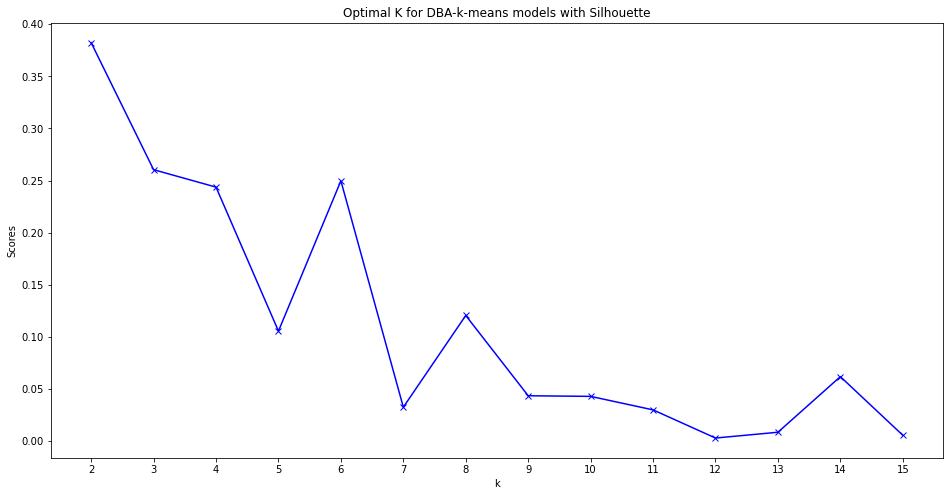

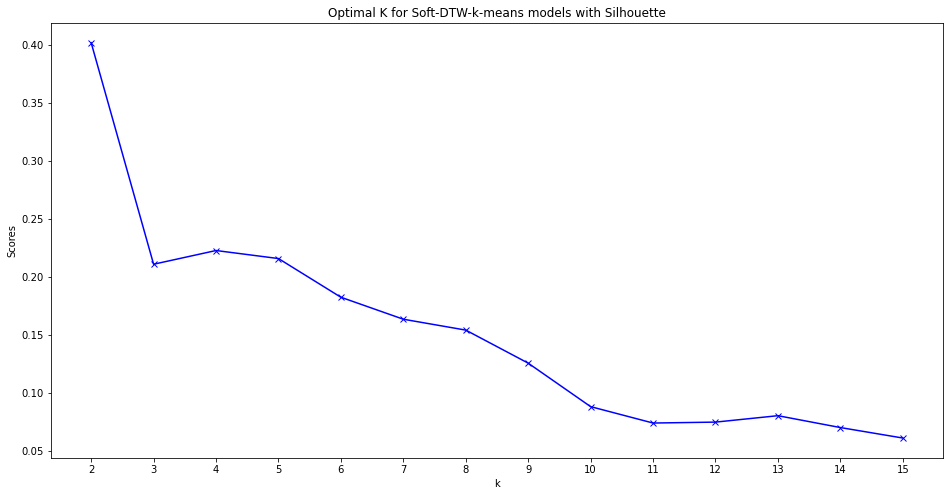

In [41]:
draw_evaluate_graph(K, s_scores["euclid"], "Optimal K for Euclid-k-means models with Silhouette", "Scores")
draw_evaluate_graph(K, s_scores["dba"], "Optimal K for DBA-k-means models with Silhouette", "Scores")
draw_evaluate_graph(K, s_scores["sdtw"], "Optimal K for Soft-DTW-k-means models with Silhouette", "Scores")

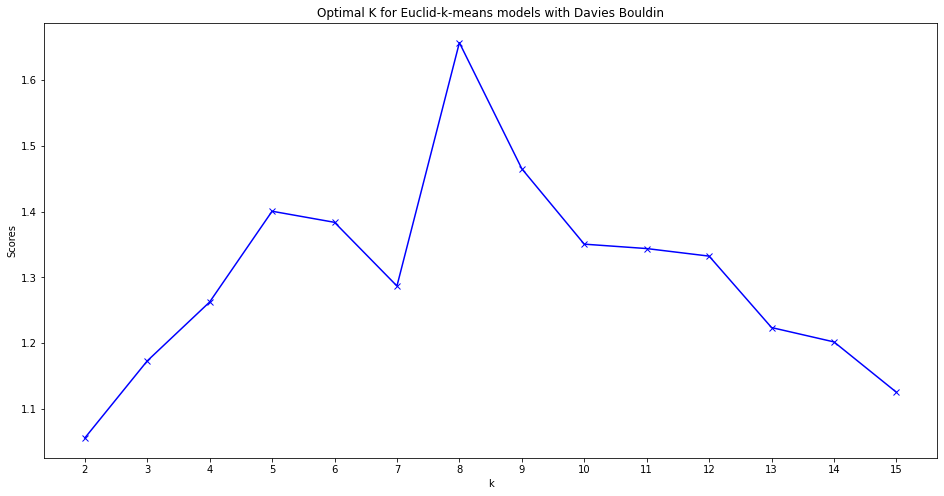

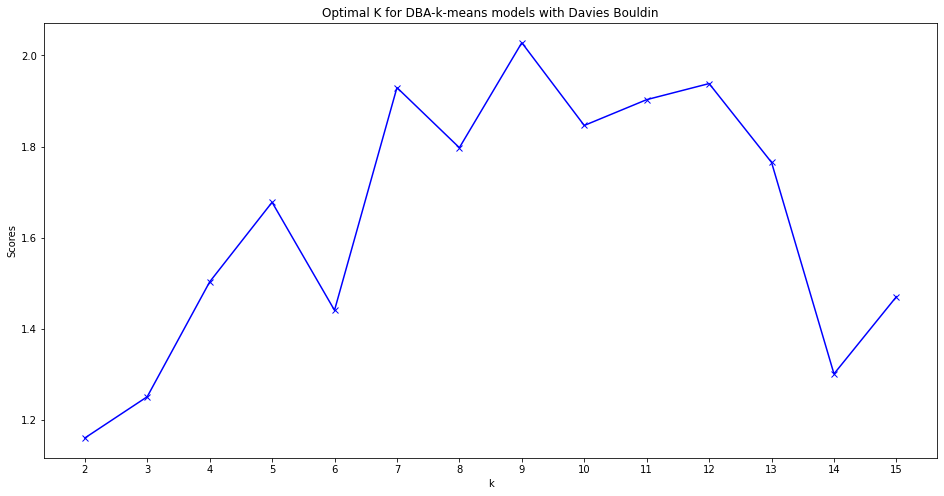

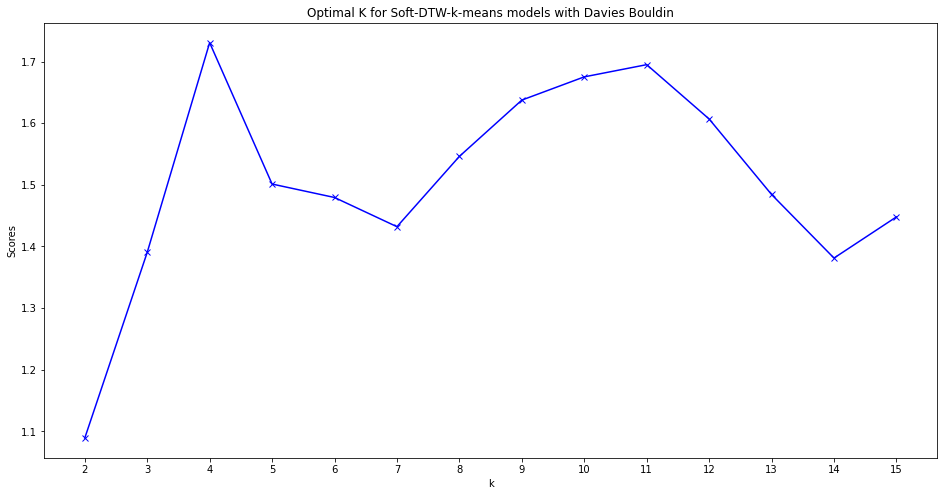

In [42]:
draw_evaluate_graph(K, db_scores["euclid"], "Optimal K for Euclid-k-means models with Davies Bouldin", "Scores")
draw_evaluate_graph(K, db_scores["dba"], "Optimal K for DBA-k-means models with Davies Bouldin", "Scores")
draw_evaluate_graph(K, db_scores["sdtw"], "Optimal K for Soft-DTW-k-means models with Davies Bouldin", "Scores")

In [13]:
# Hàm train models với k được chọn
# Đầu vào là X train và k của 3 biến thể model k-means
# Đầu ra là các gí trị dự đoán của các model khi dự đoán với X train và 3 model đã train.

def fit_predict(X_train, km_k, dba_k, sdtw_k):
    print("Training with:")
    print("Euclidean k-means k =", km_k)
    print("DBA k-means k =", dba_k)
    print("Soft-DTW k-means k=", sdtw_k)
    seed = 12
    # Euclidean k-means
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=km_k, verbose=True, random_state=seed)
    km_ypred = km.fit_predict(X_train)

    # DBA-k-means
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=dba_k,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    dba_ypred = dba_km.fit_predict(X_train)

    # Soft-DTW-k-means
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=sdtw_k,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    sdtw_ypred = sdtw_km.fit_predict(X_train)
    print("Done!")
    return km_ypred, dba_ypred, sdtw_ypred, km, dba_km, sdtw_km

In [14]:
km_ypred, dba_ypred, sdtw_ypred, km, dba_km, sdtw_km = fit_predict(X_train, km_k=6, dba_k=6, sdtw_k=6)

Training with:
Euclidean k-means k = 6
DBA k-means k = 6
Soft-DTW k-means k= 6
Euclidean k-means
102.999 --> 63.037 --> 60.469 --> 60.341 --> 60.235 --> 60.235 --> 
DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

23.584 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


12.688 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


12.688 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

26.912 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


12.906 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.6s finished


12.823 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.6s finished


12.719 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


12.669 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


11.682 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.6s finished


11.613 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


11.613 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    0.5s finished


Soft-DTW k-means
1041.151 --> 199.632 --> 196.759 --> 196.526 --> 196.109 --> 195.951 --> 195.948 --> 195.845 --> 195.904 --> 195.785 --> 195.811 --> 195.670 --> 195.758 --> 195.600 --> 195.712 --> 195.566 --> 195.618 --> 195.536 --> 195.599 --> 195.519 --> 195.576 --> 195.502 --> 195.561 --> 195.505 --> 195.557 --> 195.508 --> 195.554 --> 195.506 --> 195.564 --> 195.503 --> 195.558 --> 195.518 --> 195.566 --> 195.523 --> 195.555 --> 195.523 --> 195.564 --> 195.520 --> 195.553 --> 195.520 --> 195.554 --> 195.526 --> 195.530 --> 195.515 --> 195.516 --> 195.504 --> 195.525 --> 195.482 --> 195.499 --> 195.471 --> 
Done!


In [76]:
# Hàm vẽ biểu đồ trực quan các series sau khi phân cụm
# Đầu vào là:
# X train, 
# model k-means đã train, 
# số cụm đã chọn để train, 
# giá trị dự đoán với X train, 
# số biểu đồ nhỏ được xếp theo hàng và cột,
# Tên biểu đồ

def draw_cluster_graph(X_train, model, n_cluster, y_pred, n_row, n_col, title):
    sz = X_train.shape[1]
    plt.figure(figsize=(8,6))
    
    for yi in range(n_cluster):
        plt.subplot(n_row, n_col, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(title)
    plt.tight_layout()
    plt.show()

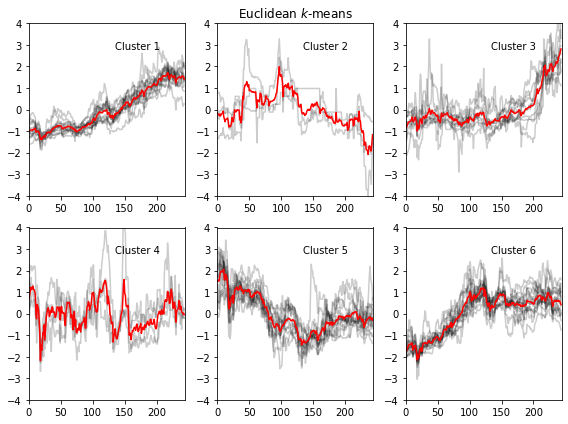

In [77]:
# Vẽ biểu đồ trực quan các series theo cụm với Euclidean k-means model
draw_cluster_graph(X_train, km, 6, km_ypred, 2,3, "Euclidean $k$-means")

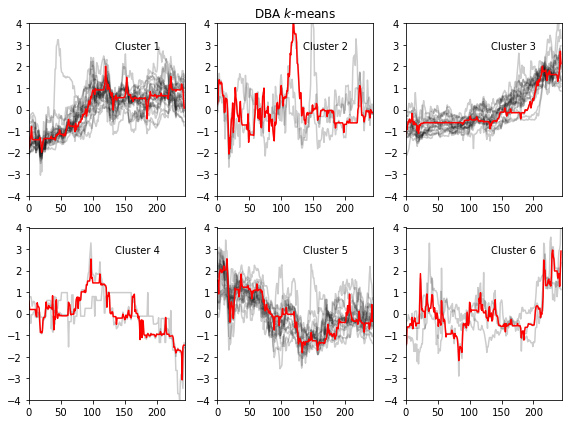

In [78]:
# Vẽ biểu đồ trực quan các series theo cụm với DBA k-means model
draw_cluster_graph(X_train, dba_km, 6, dba_ypred, 2, 3, "DBA $k$-means")

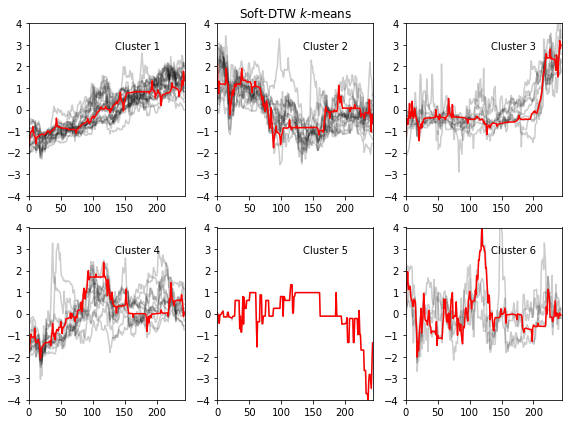

In [79]:
# Vẽ biểu đồ trực quan các series theo cụm với Soft-DTW k-means model
draw_cluster_graph(X_train, sdtw_km, 6, sdtw_ypred, 2, 3, "Soft-DTW $k$-means")

In [80]:
# Thử nghiệm với phương pháp normalize TimeSeriesScalerMinMax
X_train_2 = TimeSeriesScalerMinMax().fit_transform(df)
print(X_train_2.shape)
print(X_train_2.max())
print(X_train_2.min())

(60, 244, 1)
1.0
0.0


Range of original series:  (27.57, 58.0)
Range of scaled series:  (0.0, 1.0)


<Figure size 432x288 with 0 Axes>

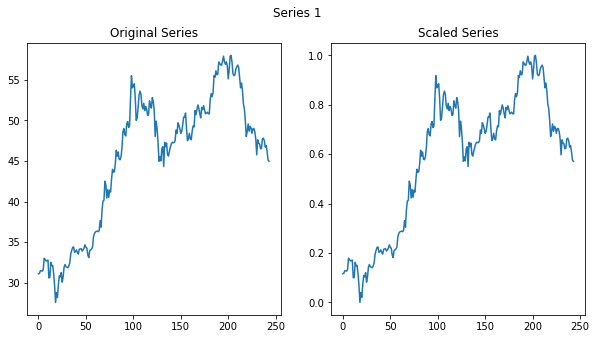

Range of original series:  (10.8, 19.5)
Range of scaled series:  (0.0, 1.0)


<Figure size 432x288 with 0 Axes>

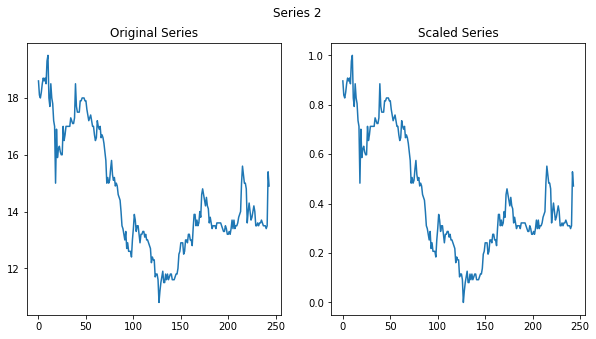

Range of original series:  (55.25, 84.0)
Range of scaled series:  (0.0, 1.0)


<Figure size 432x288 with 0 Axes>

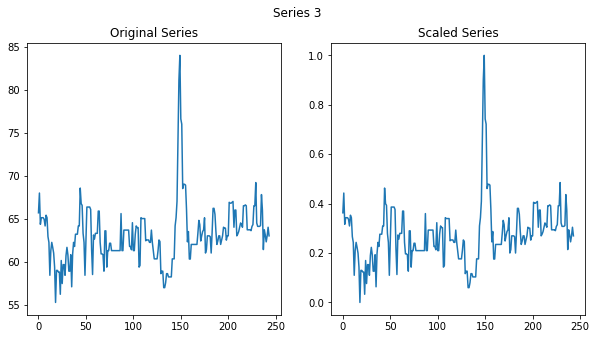

Range of original series:  (46.0, 65.6)
Range of scaled series:  (0.0, 1.0)


<Figure size 432x288 with 0 Axes>

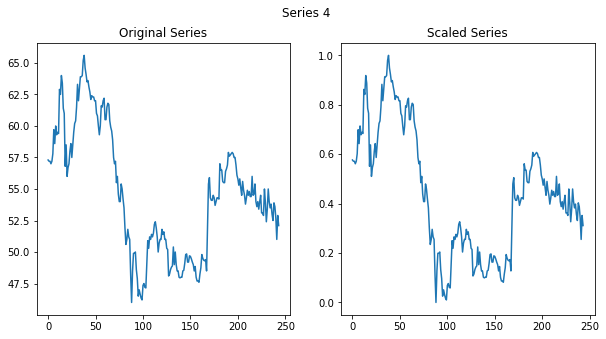

Range of original series:  (8.88, 27.7)
Range of scaled series:  (0.0, 1.0)


<Figure size 432x288 with 0 Axes>

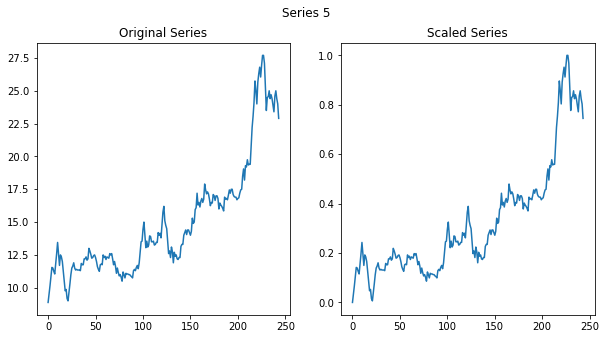

In [81]:
draw_compare_graph(df.to_numpy(), X_train_2)

In [59]:
K, inertias_2, distortions_2, ch_scores_2, s_scores_2, db_scores_2 = get_models_metrics(X_train_2)

Training with k = 2 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 3 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 4 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 5 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 6 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 7 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 8 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 9 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 10 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 11 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 12 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 13 ...
Euclidean k-means...
DBA k-means...
Soft-DTW k-means...
Training with k = 14 ...
Euclidean k

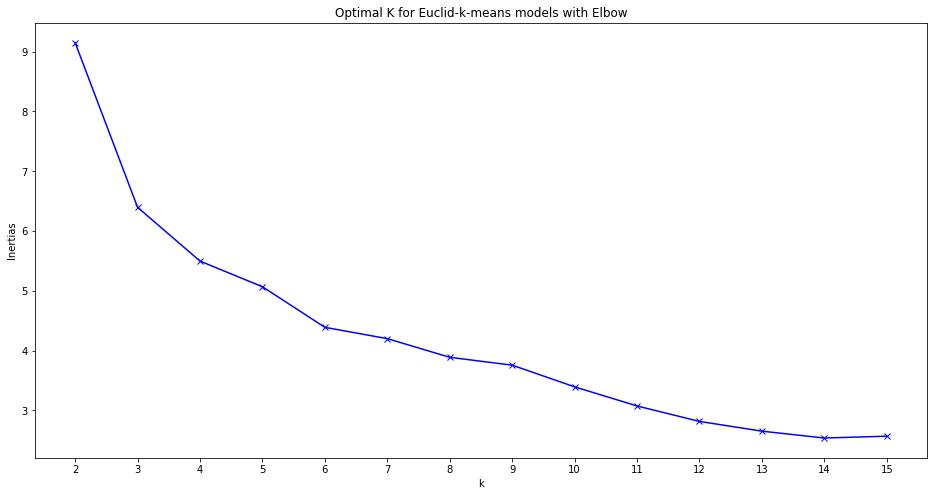

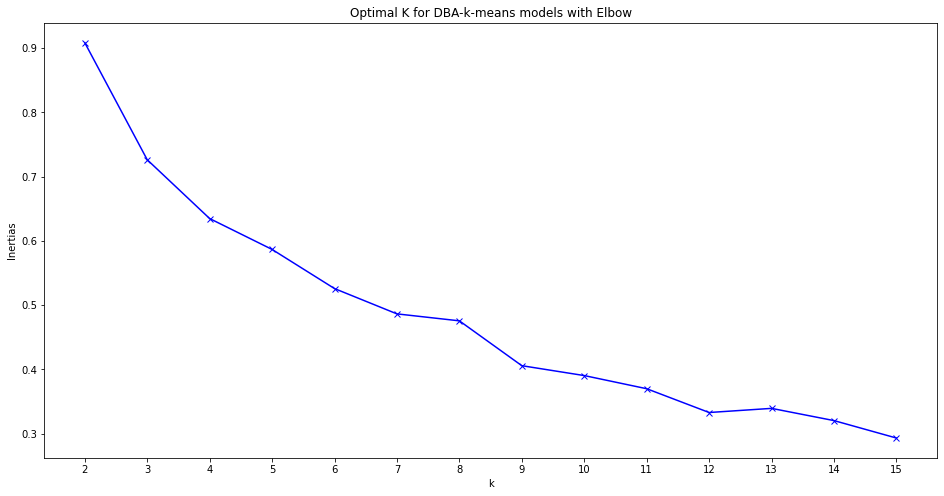

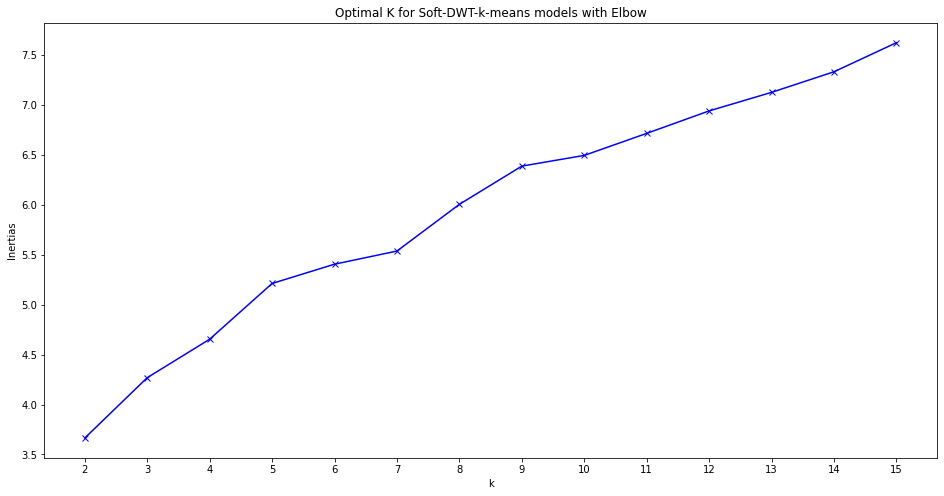

In [60]:
draw_evaluate_graph(K, inertias_2["euclid"], "Optimal K for Euclid-k-means models with Elbow", "Inertias")
draw_evaluate_graph(K, inertias_2["dba"], "Optimal K for DBA-k-means models with Elbow", "Inertias")
draw_evaluate_graph(K, inertias_2["sdtw"], "Optimal K for Soft-DWT-k-means models with Elbow", "Inertias")

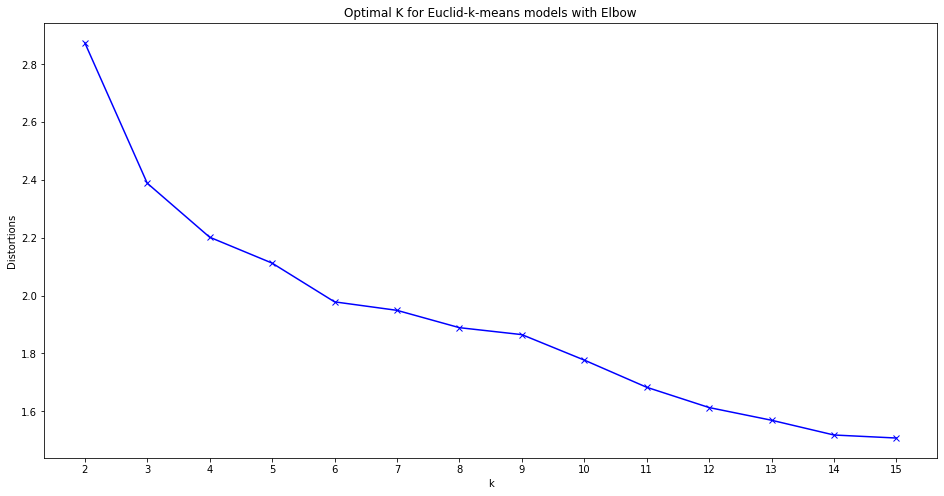

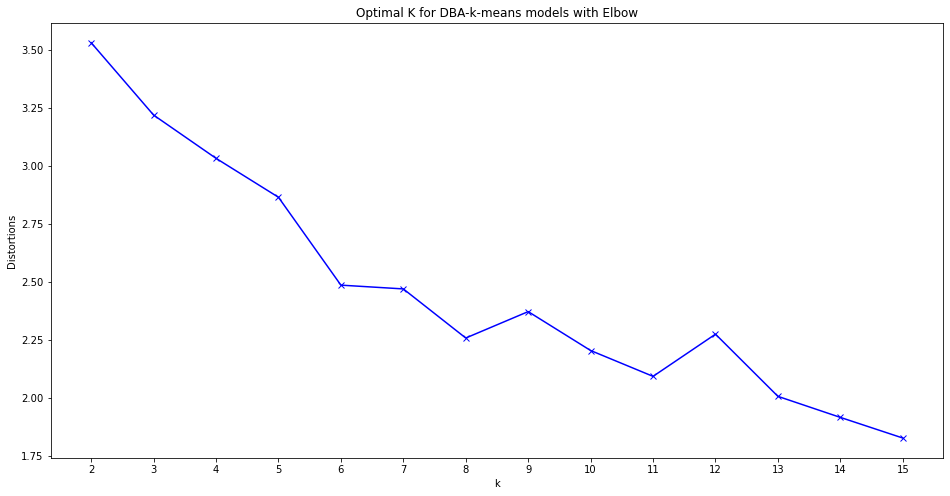

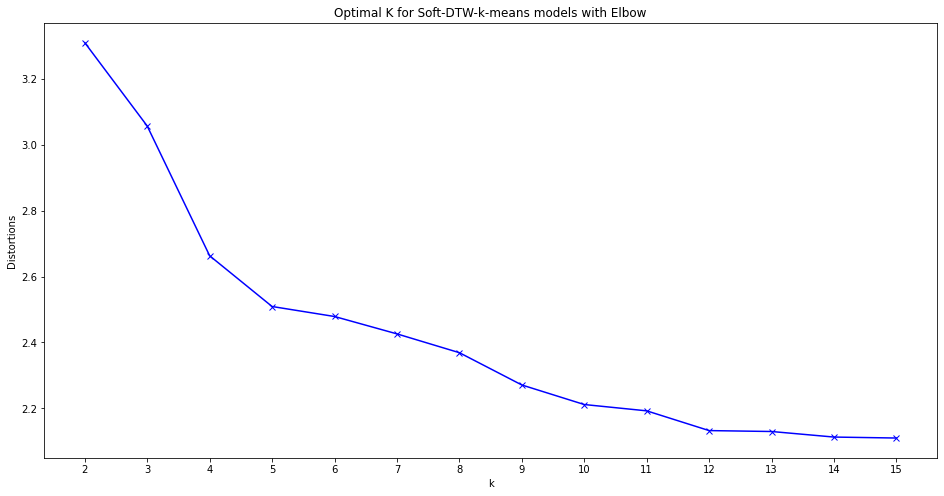

In [63]:
draw_evaluate_graph(K, distortions_2["euclid"], "Optimal K for Euclid-k-means models with Elbow", "Distortions")
draw_evaluate_graph(K, distortions_2["dba"], "Optimal K for DBA-k-means models with Elbow", "Distortions")
draw_evaluate_graph(K, distortions_2["sdtw"], "Optimal K for Soft-DTW-k-means models with Elbow", "Distortions")

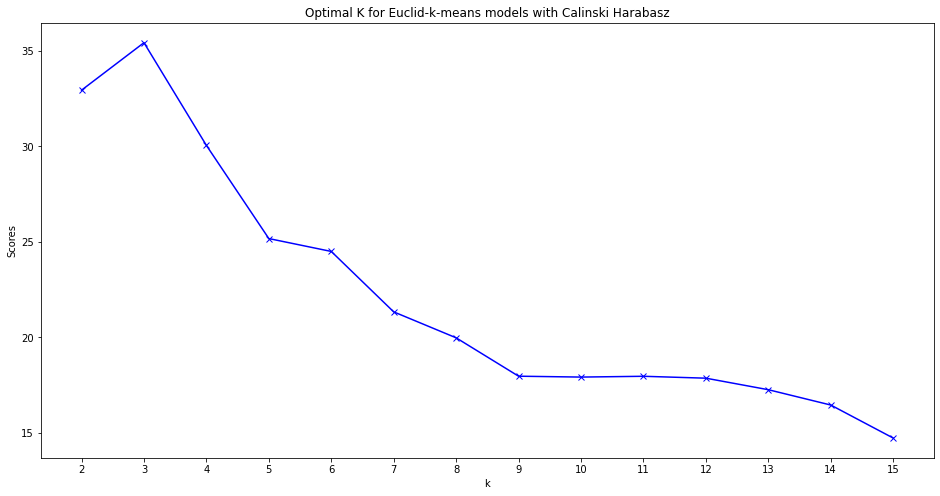

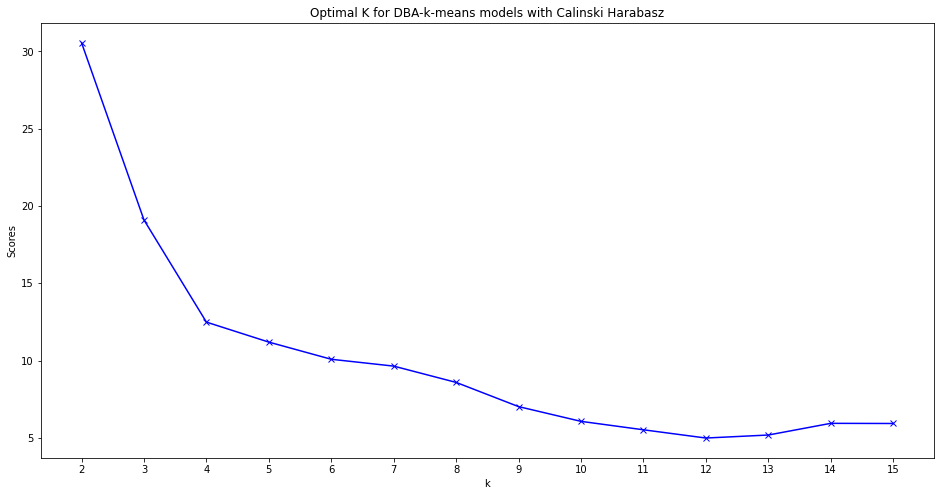

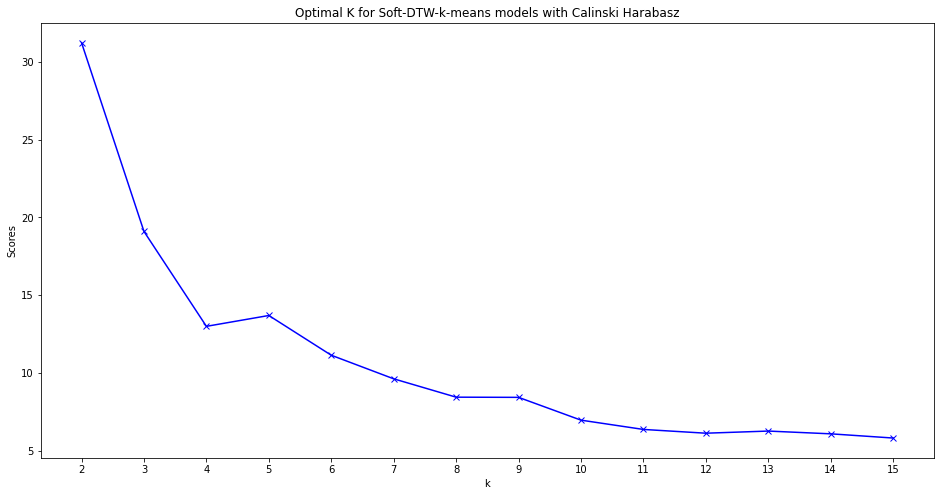

In [61]:
draw_evaluate_graph(K, ch_scores_2["euclid"],"Optimal K for Euclid-k-means models with Calinski Harabasz", "Scores")
draw_evaluate_graph(K, ch_scores_2["dba"],"Optimal K for DBA-k-means models with Calinski Harabasz", "Scores")
draw_evaluate_graph(K, ch_scores_2["sdtw"],"Optimal K for Soft-DTW-k-means models with Calinski Harabasz", "Scores")

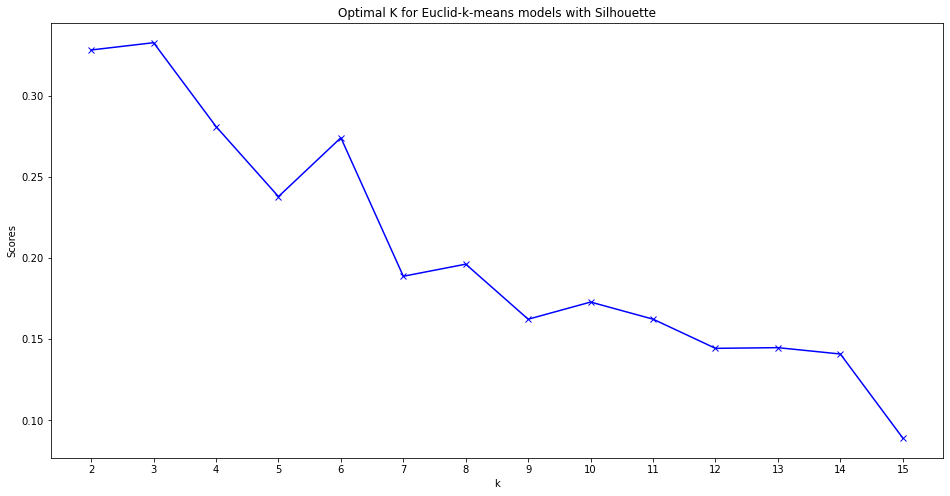

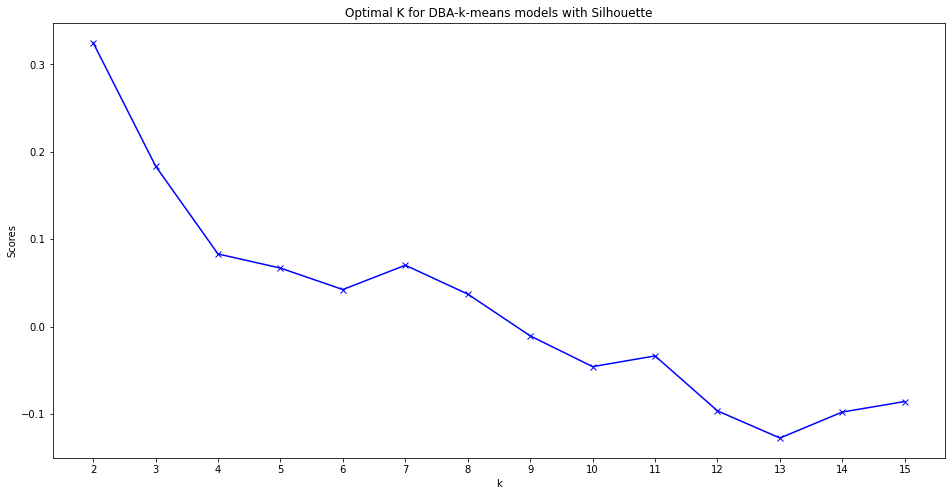

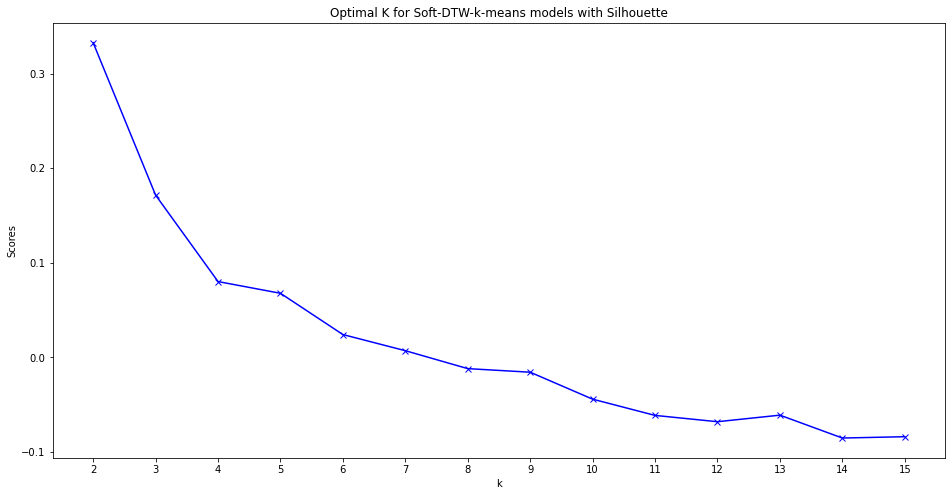

In [64]:
draw_evaluate_graph(K, s_scores_2["euclid"], "Optimal K for Euclid-k-means models with Silhouette", "Scores")
draw_evaluate_graph(K, s_scores_2["dba"], "Optimal K for DBA-k-means models with Silhouette", "Scores")
draw_evaluate_graph(K, s_scores_2["sdtw"], "Optimal K for Soft-DTW-k-means models with Silhouette", "Scores")

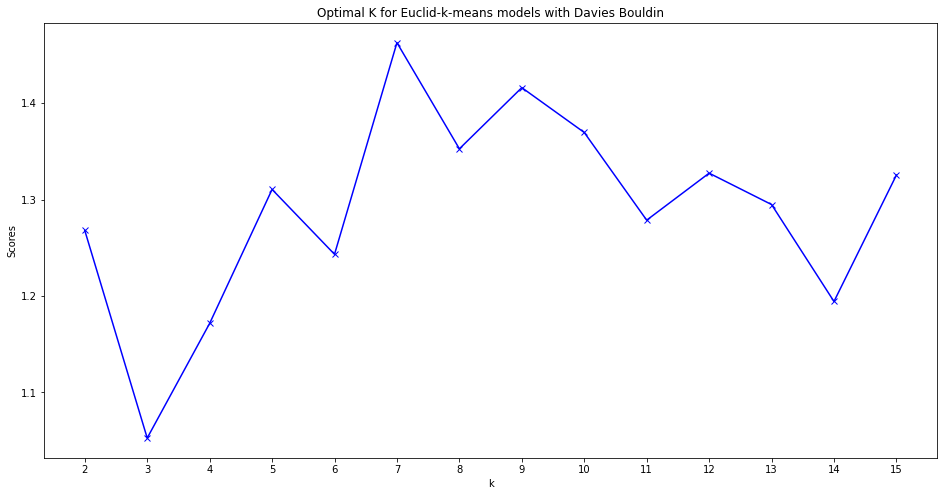

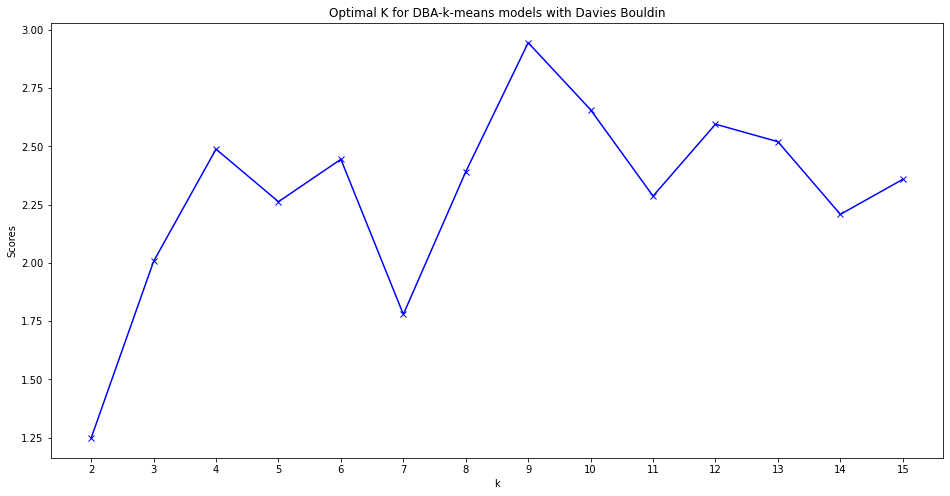

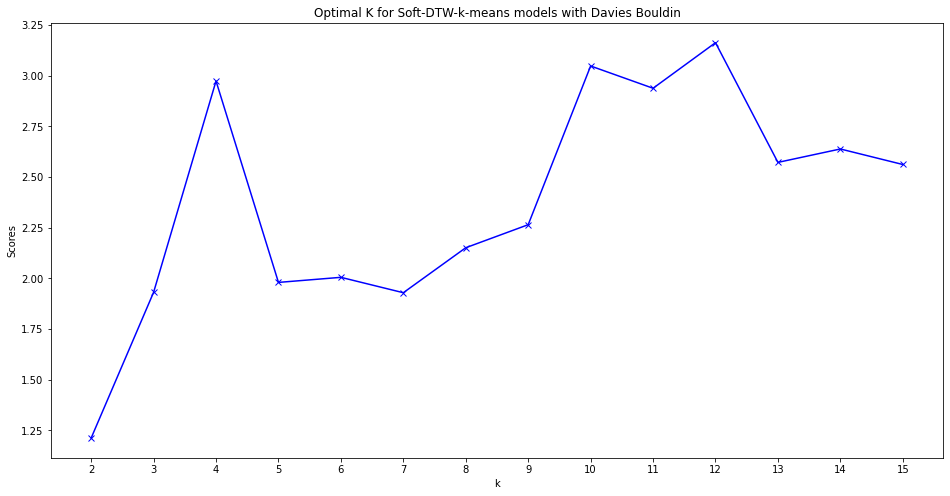

In [65]:
draw_evaluate_graph(K, db_scores_2["euclid"], "Optimal K for Euclid-k-means models with Davies Bouldin", "Scores")
draw_evaluate_graph(K, db_scores_2["dba"], "Optimal K for DBA-k-means models with Davies Bouldin", "Scores")
draw_evaluate_graph(K, db_scores_2["sdtw"], "Optimal K for Soft-DTW-k-means models with Davies Bouldin", "Scores")

In [66]:
km_ypred_2, dba_ypred_2, sdtw_ypred_2, km_2, dba_km_2, sdtw_km_2 = fit_predict(X_train_2, km_k=6, dba_k=7, sdtw_k=5)

Training with:
Euclidean k-means k = 6
DBA k-means k = 7
Soft-DTW k-means k= 5
Euclidean k-means
7.962 --> 4.982 --> 4.745 --> 4.668 --> 4.619 --> 4.581 --> 4.479 --> 4.444 --> 4.411 --> 4.389 --> 4.389 --> 
DBA k-means
Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

1.030 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.5s finished


0.525 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.6s finished


0.525 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.6s finished


0.525 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.923 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.6s finished


0.486 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.5s finished


0.486 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.5s finished


Soft-DTW k-means
3.981 --> 5.092 --> 5.183 --> 5.180 --> 5.188 --> 5.190 --> 5.193 --> 5.192 --> 5.195 --> 5.193 --> 5.197 --> 5.196 --> 5.197 --> 5.196 --> 5.198 --> 5.198 --> 5.199 --> 5.199 --> 5.200 --> 5.199 --> 5.198 --> 5.201 --> 5.202 --> 5.202 --> 5.203 --> 5.203 --> 5.204 --> 5.204 --> 5.205 --> 5.206 --> 5.207 --> 5.206 --> 5.208 --> 5.208 --> 5.209 --> 5.208 --> 5.210 --> 5.209 --> 5.211 --> 5.210 --> 5.211 --> 5.211 --> 5.212 --> 5.211 --> 5.212 --> 5.212 --> 5.213 --> 5.212 --> 5.213 --> 5.213 --> 
Done!


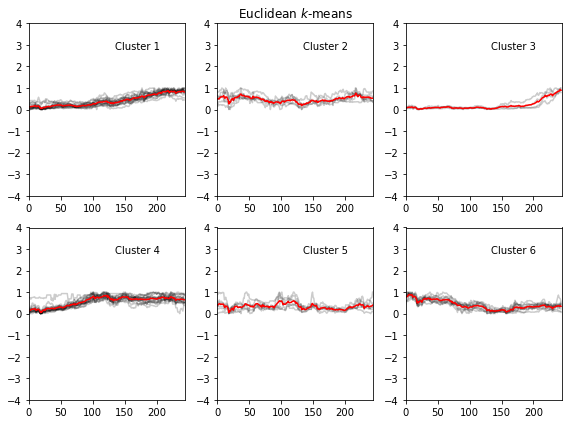

In [82]:
draw_cluster_graph(X_train_2, km_2, 6, km_ypred_2, 2,3, "Euclidean $k$-means")

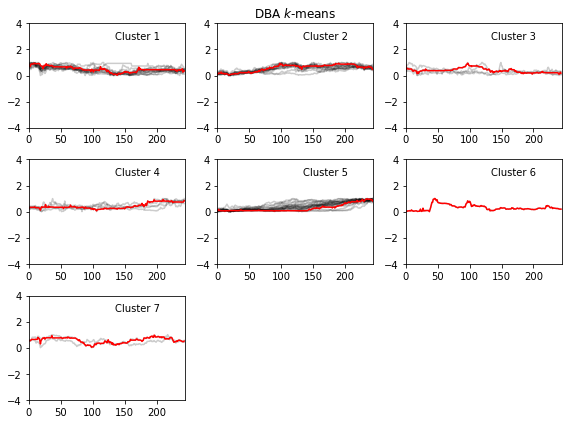

In [83]:
draw_cluster_graph(X_train_2, dba_km_2, 7, dba_ypred_2, 3, 3, "DBA $k$-means")

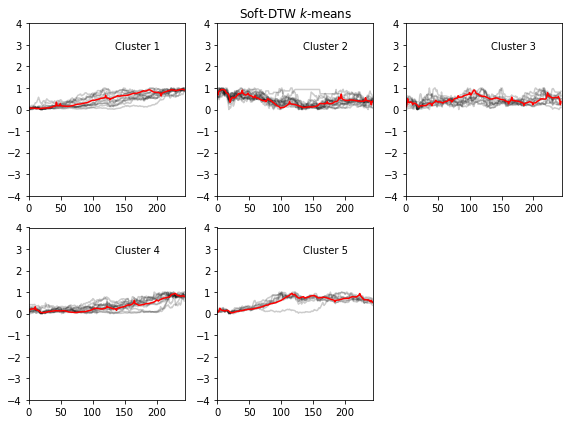

In [85]:
draw_cluster_graph(X_train_2, sdtw_km_2, 5, sdtw_ypred_2, 2, 3, "Soft-DTW $k$-means")

In [ ]:
# for series in series_list:
#     mm_scaler = MinMaxScaler()
#     std_scaler = StandardScaler()
#     ma_scaler = MaxAbsScaler()
    
#     X1.append(mm_scaler.fit_transform(series))
#     X2.append(std_scaler.fit_transform(series))
#     X4.append(ma_scaler.fit_transform(series))